<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-GIA-model-weights-(LIG)" data-toc-modified-id="Load-GIA-model-weights-(LIG)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load GIA model weights (LIG)</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Load-GIA-Models" data-toc-modified-id="Load-GIA-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load GIA Models</a></span></li><li><span><a href="#Calculations-for-Figure" data-toc-modified-id="Calculations-for-Figure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculations for Figure</a></span></li><li><span><a href="#Make-Figure" data-toc-modified-id="Make-Figure-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Make Figure</a></span></li></ul></div>

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[1]
import pandas as pd
from scipy.ndimage import gaussian_filter as gaussian

import sys
sys.path.append(str(PROJECT_ROOT))
from bahamas_lig.config import data_dir
from bahamas_lig.config import model_dir
from bahamas_lig.utils import get_model_status, load, plot_gmsl_inference, interpolation_functions
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import os

from matplotlib import markers
from matplotlib.path import Path
import arviz as az
import string
from scipy.stats import gaussian_kde

### Load GIA model weights (LIG)

In [49]:
year=2023
lig_model_dir = PROJECT_ROOT / "model_outputs/output_glac_w_ice6g"
lig_inference_dir = PROJECT_ROOT / "model_outputs/"
lig_dataframe = get_model_status(lig_inference_dir,lig_model_dir,year=year)

### Load data

In [50]:
def load_data(data_file):

    df=pd.read_excel(data_dir/f'raw/{data_file}',header=1)
    data = {}
    filtered = df[df['Indicative \nRange (m)']!='(limiting)']
    data["lon"] = filtered['Longitude'].dropna().values
    data["lat"] = filtered['Latitude'].dropna().values
    data["age"] = filtered['Age\n(ka BP)'].dropna().values
    data["age_uncertainty"] = filtered['Age Error\n(1σ, ka)'].dropna().values
    data["elevation"] = filtered['Relative Sea \nLevel (m)'].dropna().values
    data["elevation_uncertainty"] = filtered['RSL Error \n(1σ, m)'].dropna().values
    data["type"] = ['index' for l in filtered['Indicative \nRange (m)'].dropna()]
    data["lower_limit"] = filtered['RSL (m)\n(limiting min)'].dropna().values
    data["region"] = filtered['Region'].dropna().values
    #     keys = [mapping_uplift[i] for i in data['region']]
    data["uplift_rate (per ky)"] = filtered['uplift rate *** (mean, m/kyr)'].dropna().values
    data["uplift_rate (per ky)"] = [a for a in data["uplift_rate (per ky)"] if type(a) == type(2.3)]
    data["uplift_rate (std)"] = filtered['uplift rate *** (1σ, m/kyr)'].dropna().values

    data=pd.DataFrame.from_dict(data)
    # data['elevation'][data['elevation']=='(limiting)']=filtered['RSL (limiting)'].dropna().values
    data['elevation']=pd.to_numeric(data['elevation'])
    return data.copy()

data_file = "Barnett_EuropeLIG_SuppData_April2023_V2.2.xlsx"
data = load_data(data_file)


### Load GIA Models

In [51]:
def load_model(name):
    output_dir = 'output_glac_w_ice6g/'

    lats = pd.read_csv(model_dir / "lats", delimiter=",", header=None)
    lons = pd.read_csv(model_dir / "lons", delimiter=",", header=None)
    directory = model_dir / output_dir
#     age = np.arange(115, 131, 1)

    extent = [0, 1, 0, 1]
    model_dims = [
        np.min(lons.values),
        np.max(lons.values),
        np.min(lats.values),
        np.max(lats.values),]

    files = np.sort(os.listdir(directory))
    files = [f for f in files if 'output' in f]  # ignores non output
    
    files = [f for f in files if name in f]

    rsl = []
    age=[]
    for i in range(0, len(files)):
        rsl.append(
        pd.read_csv(
            str(directory) + "/" + files[i], delimiter=",", header=None
        ).values
        )
        age.append(float(files[i].split('ka')[0].split('_')[-1]))
    return rsl, age, model_dims

def pre_load_models(comp):
    models = {}
    ages = {}
    for m in tqdm(list(comp[comp['posterior_predict']==True].index)):
        GIA_MODEL, age, model_dims = load_model(m)
        models[m] = GIA_MODEL
        ages[m] = age
    return models,ages

models,ages = pre_load_models(lig_dataframe)

  0%|          | 0/600 [00:00<?, ?it/s]

### Calculations for Figure

In [52]:
data['region_cluster']=''
data.loc[data['region']=='Jutland','region_cluster']='Jutland'
data.loc[data['region']=='Yorkshire','region_cluster']='Central UK'
data.loc[data['region']=='Normandy','region_cluster']='Normandy'
data.loc[data['region']=='Jersey','region_cluster']='Normandy'
data.loc[data['region']=='Sussex','region_cluster']='South UK'
data.loc[data['region']=='Isle of Wight','region_cluster']='South UK'
data.loc[data['region']=='Cornwall','region_cluster']='South UK'
data.loc[data['region']=='Devon','region_cluster']='South UK'
data.loc[data['region']=='Wales','region_cluster']='South UK'

In [53]:

def align_marker(marker, halign='center', valign='middle',h_adjust=0):
    """
    create markers with specified alignment.

    Parameters
    ----------

    marker : a valid marker specification.
      See mpl.markers

    halign : string, float {'left', 'center', 'right'}
      Specifies the horizontal alignment of the marker. *float* values
      specify the alignment in units of the markersize/2 (0 is 'center',
      -1 is 'right', 1 is 'left').

    valign : string, float {'top', 'middle', 'bottom'}
      Specifies the vertical alignment of the marker. *float* values
      specify the alignment in units of the markersize/2 (0 is 'middle',
      -1 is 'top', 1 is 'bottom').

    Returns
    -------

    marker_array : numpy.ndarray
      A Nx2 array that specifies the marker path relative to the
      plot target point at (0, 0).

    Notes
    -----
    The mark_array can be passed directly to ax.plot and ax.scatter, e.g.::

        ax.plot(1, 1, marker=align_marker('>', 'left'))

    """

    if isinstance(halign, (str)):
        halign = {'right': -1.,
                  'middle': 0.,
                  'center': 0.,
                  'left': 1.,
                  'other':h_adjust,
                  }[halign]

    if isinstance(valign, (str)):
        valign = {'top': -1.,
                  'middle': 0.,
                  'center': 0.,
                  'bottom': 1.,
                  }[valign]

    # Define the base marker
    bm = markers.MarkerStyle(marker)

    # Get the marker path and apply the marker transform to get the
    # actual marker vertices (they should all be in a unit-square
    # centered at (0, 0))
    m_arr = bm.get_path().transformed(bm.get_transform()).vertices

    # Shift the marker vertices for the specified alignment.
    m_arr[:, 0] += halign / 2
    m_arr[:, 1] += valign / 2

    return Path(m_arr, bm.get_path().codes)

In [54]:

model_posterior_dir = str(model_dir)+'/'+str(f'arviz_traces_{year}')
model_posterior_list=[o[:-3] for o in os.listdir(model_posterior_dir) if '.nc' in o]    

all_traces = {}
for f in tqdm(model_posterior_list):
    all_traces[f]=az.from_netcdf(model_posterior_dir+'/'+f+'.nc')

  0%|          | 0/600 [00:00<?, ?it/s]

In [55]:
iters=10000 #more iterations for smoother posteriors
comp = lig_dataframe
model_names = list(comp.index)
weighted_post_samples =[]
for i in tqdm(range(iters)):
    choice = np.random.choice(np.arange(len(comp)), 1, p=comp['weight'])
    key=comp.index[choice][0]
    i=np.random.choice(np.arange(4000),1)
    weighted_post_samples.append(all_traces[key].posterior.ages.values.reshape((1,-1,20))[0,i,:].ravel())
    
weighted_post_samples=np.array(weighted_post_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
dt = np.linspace(128,117,1000)

lo = np.percentile(weighted_post_samples,2.5,axis=0)
hi = np.percentile(weighted_post_samples,97.5,axis=0)
lo33 = np.percentile(weighted_post_samples,16,axis=0)
hi66 = np.percentile(weighted_post_samples,84,axis=0)
most_like = np.zeros_like(lo)

for i in range(lo.size):
    like_fun = gaussian_kde(weighted_post_samples[:,i])
    most_like[i] = dt[np.argmax(like_fun(dt))]

In [57]:
data=data.sort_values(['type'])

data['post_age_lo2p5']=lo
data['post_age_hi97p5']=hi
data['post_age_lo16']=lo33
data['post_age_hi84']=hi66
data['post_age_max_like']=most_like
data['posterior_index']=np.arange(len(data))


In [58]:
lig_predict_dir = str(lig_inference_dir)+'/'+str(f'pymc3_post_predict_{year}')
lig_predict_list=[o[:-4] for o in os.listdir(lig_predict_dir) if '.pkl' in o]

In [59]:
preds = {}
for f in tqdm(lig_predict_list):
    preds[f]=load(lig_predict_dir+'/'+f+'.pkl')

  0%|          | 0/600 [00:00<?, ?it/s]

In [60]:
def weighted_trace(pred_list, comp, var="f_pred", iters=20000):
    weighted_trace =[]
    choices = []
    
    for i in range(iters):
        choice = np.random.choice(np.arange(len(comp)), 1, p=comp['weight'])
        key=comp.index[choice][0]
        choices.append(key)
        f_preds = pred_list[key][var]
        C=np.random.choice(np.arange(len(f_preds)), 1)
        gmsl=f_preds[C].ravel()
        weighted_trace.append(gmsl)
        
    weighted_trace=np.array(weighted_trace)

    return weighted_trace,choices

In [61]:
gmsl,choices=weighted_trace(preds,lig_dataframe,iters=10000)
inferences=[gmsl]
X_new = np.linspace(115, 130, 200)[:, np.newaxis]
within_LIG = np.logical_and(X_new>=117,X_new<=128)

gmsl=np.array([g for g in gmsl if not all(np.isnan(g))])
peak_gmsl=np.nanmax(gmsl[:,within_LIG.ravel()],axis=1)
maxes=np.argmax(gmsl,axis=1)
A=X_new.ravel()[maxes]
bandwidth_for_kde=0.1
f_size=12

sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".95",
        "grid.linestyle": u"--",
    },
)
flatui = ["#D08770", "#BF616A", "#A3BE8C", "#B48EAD", "#34495e", "#5E81AC"]
cs = sns.color_palette(flatui)



In [62]:
inference=gmsl
dy = np.linspace(-15,25,200)
max_like = np.zeros(X_new.size)
for i in range(X_new.size):
    time_slice = inference[:,i][~np.isnan(inference[:,i])]
    max_like[i]=dy[np.argmax(gaussian_kde(time_slice,bw_method=1)(dy))]
max_like = gaussian(max_like,2)

In [63]:
np.savetxt(data_dir/"processed/gmsl_all.csv", gmsl, delimiter=",")
np.savetxt(data_dir/"processed/time.csv", X_new.ravel(), delimiter=",")
np.savetxt(data_dir/"processed/gmsl_2sig_lo.csv", np.nanpercentile(inference, 2.5, axis=0), delimiter=",")
np.savetxt(data_dir/"processed/gmsl_2sig_hi.csv", np.nanpercentile(inference, 97.5, axis=0), delimiter=",")
np.savetxt(data_dir/"processed/gmsl_1sig_lo.csv", np.nanpercentile(inference, 32/2, axis=0), delimiter=",")
np.savetxt(data_dir/"processed/gmsl_1sig_hi.csv", np.nanpercentile(inference, 100-32/2, axis=0), delimiter=",")
np.savetxt(data_dir/"processed/gmsl_max_like.csv", max_like, delimiter=",")
pd.DataFrame(choices).to_csv(data_dir/"processed/model_pairs.csv")

### Make Figure

In [64]:
def weighted_rsl_trace(pred_list, comp, lat, lon, uplift_rate, var="f_pred",iters=20000):
    model_names = list(comp.index)
    weighted_trace =[]
    for i in range(iters):
        choice = np.random.choice(np.arange(len(comp)), 1, p=comp['weight'])
        key=comp.index[choice][0]
        f_preds = pred_list[key][var]
        C=np.random.choice(np.arange(len(f_preds)), 1)
        gmsl=f_preds[C].ravel()
        
        GIA_MODEL = models[key]
        age = ages[key]
        
        if i == 0:
            GIA_MODEL, age, model_dims = load_model(key)
            
        z_functions = interpolation_functions(
            [lat], [lon], GIA_MODEL, age, model_dims
        )
        
        GIA_to_add = z_functions[0](X_new).ravel()
        
        uplift_to_add = uplift_rate*X_new.ravel()
        
        weighted_trace.append(GIA_to_add+gmsl+uplift_to_add)
    weighted_trace=np.array(weighted_trace)
    return weighted_trace


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-65-fd8a17531354>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=fig.add_subplot(gs[1, k*4:k*4+4])


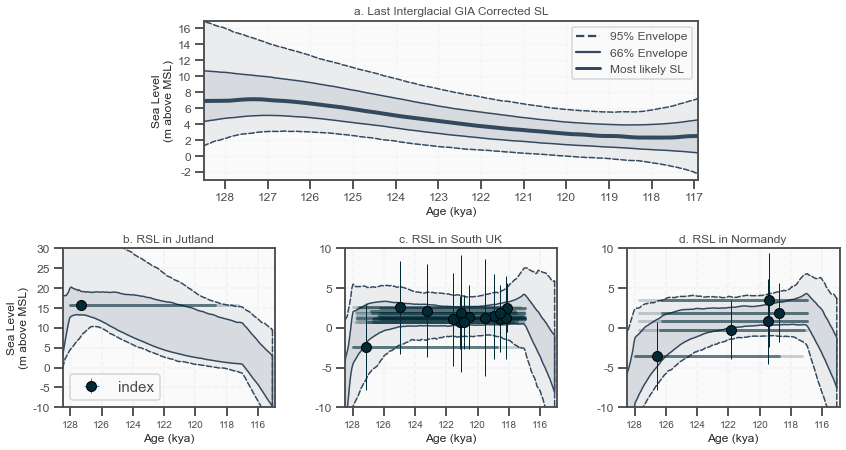

In [65]:
X_new = np.linspace(115, 130, 200)[:, np.newaxis]
within_LIG = np.logical_and(X_new>115,X_new<130)


regions = data['region_cluster'].unique()
locs = {}
for r in regions:
    locs[r]={}
    locs[r]['Latitude']=data[data['region_cluster']==r]['lat'].mean()
    locs[r]['Longitude']=data[data['region_cluster']==r]['lon'].mean()
    locs[r]['uplift_rate (per ky)'] = data[data['region_cluster']==r]['uplift_rate (per ky)'].mean()

k=0

color_list=[8,6,7]
sns.set_context('talk')
sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".95",
        "grid.linestyle": u"--",
    },
)
f_size=12
bandwidth_for_kde=0.05

flatui = ["#D08770", "#BF616A", "#A3BE8C", "#B48EAD", "#34495e", "#5E81AC","#268bd2", "#cb4b16", "#002b36"]
cs = sns.color_palette(flatui)

letters=list(string.ascii_uppercase)



fig = plt.figure(figsize=(11*1.1,6*1.1))
gs = gridspec.GridSpec(2, 12)
ax1=fig.add_subplot(gs[0, 2:10])

plt.plot([],[],'--',c=cs[4],label='95% Envelope')
plt.plot([],[],'-',c=cs[4],label='66% Envelope')
plt.plot([],[],'-',lw=3,c=cs[4],label='Most likely SL')
ax1.legend(loc='best',fontsize=f_size)

plot_gmsl_inference(X_new,inferences[0],cs[4],ax1,plot_max_like=True)



plt.gca().set_title(
    "a. Last Interglacial GIA Corrected SL",
    fontsize=f_size,
)

ax1.set_ylim([-3, 17])
ax1.set_yticks([-2,0,2,4,6,8,10,12,14,16])
ax1.set_yticklabels([-2,0,2,4,6,8,10,12,14,16],fontsize=f_size)
ax1.set_xlim([116.9,128.5])
ax1.invert_xaxis()
ax1.set_xticks(np.arange(128,116,-1))
ax1.set_xticklabels(np.arange(128,116,-1),fontsize=f_size)


ax1.set_ylabel("Sea Level\n(m above MSL)", fontsize=f_size)
ax1.set_xlabel("Age (kya)",fontsize=f_size)
ax1.grid(True,linewidth=1)

ax=fig.add_subplot(gs[1, :4])

ax.errorbar(
    [],
    [],
    xerr=[],
    yerr=[],
    linestyle="none",
    label="index",mfc=cs[color_list[0]],color=cs[color_list[1]],
    marker='o',mec='k',zorder=100,lw=1,markersize=10
)


hand, labl =ax.get_legend_handles_labels()
ax.legend(hand[-2:], labl[-2:],fontsize=15,loc='lower left')

for l in tqdm(['Jutland','South UK','Normandy']):
    L = locs[l]

    ax=fig.add_subplot(gs[1, k*4:k*4+4])
    inference_all= weighted_rsl_trace(preds,lig_dataframe,
                                      L['Latitude'],L['Longitude'],
                                      uplift_rate=L['uplift_rate (per ky)']*0,
                                      iters=1000)
    

    plot_gmsl_inference(X_new[within_LIG],inference_all[:,within_LIG.ravel()],cs[4],ax,False)
    filtered = data[data['region_cluster']==l]
    
    
    for j,t in enumerate(data['type'].unique()):
        f = filtered[filtered['type']==t]
        
        xerr = [np.abs(f["post_age_max_like"]-f["post_age_lo2p5"]),np.abs(f["post_age_max_like"]-f["post_age_hi97p5"])]
        
        yerr = [2*f["elevation_uncertainty"],2*f["elevation_uncertainty"]]
        marker='o'
        markersize=10
        mew=1
        adjust=-1*f['uplift_rate (per ky)']*f["post_age_max_like"]
        extra_adjust=0
        
        if (t == 'limiting'):
            yerr = [100*f["elevation_uncertainty"],1*f["elevation_uncertainty"].fillna(0)]
            yerr = 0
            marker=align_marker('$\downarrow$',valign='top')
            markersize=35
            mew=0
            adjust=1.15-f['uplift_rate (per ky)']*f["post_age_max_like"]
            extra_adjust=1.15
        
        
        ax.errorbar(
            f["post_age_max_like"],
            f["elevation"]+adjust,
            xerr=0,
            yerr=yerr,
            linestyle="none",lw=1,
            label="Observations",mfc=cs[color_list[j]],color=cs[color_list[j]],
            marker=marker,mec='k',zorder=100,markersize=markersize,mew=mew
        )
        for item in f.index:
            item=f.loc[item,:]
            if item['type']=='limiting':
                extra_adjust=1.15
            else:
                extra_adjust=0
            like_fun = gaussian_kde(weighted_post_samples[:,item['posterior_index']])
            one_lim,two_lim = (np.percentile(like_fun(dt),2.5),np.percentile(like_fun(dt),(100-68)/2))
            one_sig = np.ma.masked_where(like_fun(dt)<one_lim,dt)
            two_sig = np.ma.masked_where(like_fun(dt)<two_lim,dt)
            ax.plot(one_sig,
                    np.ones(one_sig.size)*item["elevation"]+
                    extra_adjust-item['uplift_rate (per ky)']*item["post_age_max_like"],linestyle='-',alpha=.2,
                    lw=3,color=cs[color_list[j]],zorder=98)
            ax.plot(two_sig,np.ones(one_sig.size)*item["elevation"]+
                    extra_adjust-item['uplift_rate (per ky)']*item["post_age_max_like"],
                    linestyle='-',alpha=.5,
                    lw=3,color=cs[color_list[j]],zorder=98)
    
    
    ax.set_title(
        letters[k+1].lower() +". RSL in "+filtered['region_cluster'].values[0],fontsize=f_size)
    

    if k%3==0:
        ax.set_yticks(np.arange(-15,35,5))
        ax.set_yticklabels(np.arange(-15,35,5),fontsize=f_size)
        ax.set_ylabel("Sea Level\n(m above MSL)", fontsize=f_size)
    else:
        ax.set_yticks(np.arange(-15,35,5))
        ax.set_yticklabels(np.arange(-15,35,5),fontsize=f_size)
    ax.set_ylim([-10, 30])
    if k==1:
        ax.set_ylim([-10, 10])
    if k==2:
        ax.set_ylim([-10, 10])
    
    ax.set_xlim([128.5,114.9])

    ax.set_xticks(np.arange(128,114,-2))
    ax.set_xticklabels(np.arange(128,114,-2),fontsize=f_size-2)
    ax.set_xlabel("Age (kya)",fontsize=f_size)

    k+=1
    


sns.set_style('ticks')
sns.set_style(
    "ticks",
    {

       'axes.facecolor': 'white'

    },
)

fig.tight_layout(h_pad=1,w_pad=1)

In [66]:
fig.savefig('Figure2.pdf')

In [67]:
data.to_csv(data_dir/'processed/eu_sample_posterior_ages.csv')

In [68]:
lig_dataframe.sort_values('weight',ascending=False)

,Lithosphere,UMV,LMV,ice_history,esl_curve,posterior_trace,posterior_predict,weight
output71Cp530_ICE6G_Wael_S,71,5,30,ICE6G,S,True,True,0.057445
output_new71Cp410_L6G_Glac_Wael_T,71,4,10,L6G,T,True,True,0.055307
output96Cp510_ICE6G_Wael_S,96,5,10,ICE6G,S,True,True,0.052024
output96Cp530_ICE6G_Wael_S,96,5,30,ICE6G,S,True,True,0.049907
output71Cp57_ICE6G_Wael_S,71,5,7,ICE6G,S,True,True,0.036029
...,...,...,...,...,...,...,...,...
output48Cp530_ICE6G_Wael_T,48,5,30,ICE6G,T,True,True,0
output48Cp37_ICE6G_Wael_T,48,3,7,ICE6G,T,True,True,0
output48Cp33_ICE6G_Wael_T,48,3,3,ICE6G,T,True,True,0
output48Cp53_ICE6G_Wael_T,48,5,3,ICE6G,T,True,True,0
